In [1]:
# -*- coding: utf-8 -*-

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [20]:
import sys
import torch
import numpy as np
import pandas as pd
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [21]:
#from utils.models import FashionMNISTCNN
#from utils.basics import generic_train, test_total_accuracy, test_class_accuracy, save_model
#from utils.attacks import NoAttack, RandomAttack, TargetedAttack
#from utils.defenses import NoDefense, FlippedLabelsDefense

In [22]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [23]:
type(device)

torch.device

In [24]:
def load_data(batch_size=32):
    """
    load FashionMNIST data
    Args:
        batch_size (int, optional): the batch size. Defaults to 32.
    """        
    batch_size = batch_size
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ),)]) # normalize to [-1,1]
    trainset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    testset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
    
    classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot')
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle = True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainset, testset, trainloader, testloader

In [25]:
# Define the model
class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super(FashionMNISTCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Linear(7*7*32, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [8]:
# you have to implement the defense algorithm in here.

def aggregateModel(client_models, global_model):
    """
    global parameter updates aggregation.
    Args:
        client_models (list[torch.nn.Module]): the client models
    """    
    ### take simple mean of the weights of models ###
    #safe_clients = no_defense_run(global_model, client_models, plot_name="fig.png")
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        update = [client_models[i].state_dict()[k].float() for i in range(len(client_models))]
        global_dict[k] = torch.stack(update, axis=0).mean(axis=0)
    return global_dict

In [9]:
# Random Attack
def randomFlipAttack(inputs, labels, num_classes=10):
    labels = torch.randint(0, num_classes, (np.size(labels, axis=0),))
    return inputs, labels

In [10]:
# You will have to implement the attacks here.

def modelTrainer(model, num_epochs, trainloader, optimizer, criterion, device="cpu",attack=False, verbose=False):
    if type(device) == str:  
        device = torch.device(device) 
    model = model.to(device)
    
    model.train()

    train_losses = []
    for epoch in range(num_epochs):  # loop over the dataset multiple time
        running_loss = 0.0
        epoch_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)# get the inputs; data is a list of [inputs, labels]
            if attack:
                inputs, labels = randomFlipAttack(inputs, labels)
                labels = labels.to(device)
            inputs.to(device) 
            labels.to(device)
            optimizer.zero_grad() # zero the parameter gradients

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if verbose:
                running_loss += loss.item()
                if i % 50 == 0 and i != 0:  
                    print(f"[epoch: {epoch}, datapoint: {i}] \t loss: {round(running_loss / 50, 3)}")
                    running_loss = 0.0
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(trainloader)) #this is buggy
    return train_losses

In [11]:
def test_total_accuracy(model, testloader, device="cpu"):
    """
    compute the (pure) accuracy over a test set 
    Args:
        model (torch.nn.Module): [description]
        testloader (torch.utils.data.Dataloader): the test set dataloader
        device (str or pytorch device, optional): where to evaluate pytorch variables. Defaults to "cpu".
    Returns:
        (float): the accuracy
    """  
    if type(device) == str:  
        device = torch.device(device)
    model = model.to(device) 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [12]:
# Define FL constants
batch_size = 32
lr = 1e-3
num_epochs = 2
num_clients = 5
rounds = 50
verbose = False

In [13]:
# Number of malicious clients
num_malicious = 0
# Prepare attacks
clients_attack = [False for _ in range(num_clients)]

# Randomly select malicious clients
malicious_clients = np.random.choice(num_clients, num_malicious, replace=False)
for i in malicious_clients:
    clients_attack[i] = True

In [14]:
print(f"Malicious clients: {malicious_clients}")

Malicious clients: []


In [15]:
# Load data
trainset, testset, trainloader, testloader = load_data(batch_size=batch_size)

# prepare clients train loader
trainset_split = random_split(trainset, [int(len(trainset) / num_clients) for _ in range(num_clients)])
client_trainloaders = [DataLoader(x, batch_size=batch_size, shuffle=True) for x in trainset_split]

In [16]:
train_losses = []
model_test_acc  = []
model_global = FashionMNISTCNN()
# list of list to collect the loss of each clients
clients_loss = [[] for _ in range(num_clients)]
for r in range(rounds):
    round_loss = 0.0
    client_models = []
    for i in range(num_clients):
        # create a model
        model = FashionMNISTCNN()
        model.to(device)
        
        # Train Loader
        trainloader = client_trainloaders[i]
        model.load_state_dict(model_global.state_dict())

        # Define optimizer and loss
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
        loss = modelTrainer(
            model=model, 
            num_epochs=num_epochs, 
            trainloader=trainloader, 
            optimizer=optimizer, 
            criterion=criterion,  
            device=device, 
            attack=clients_attack[i],
            verbose=verbose)[-1]
        client_models.append(model)
        round_loss += loss
        clients_loss[i].append(loss)
        print(f"--> client {i} trained, round {r} \t final loss: {round(loss, 3)}\n")
    train_losses.append(round_loss / num_clients)
    model_global.load_state_dict(aggregateModel(client_models, model_global))
    model_test_acc.append(test_total_accuracy(model_global, testloader, device))   

--> client 0 trained, round 0 	 final loss: 0.399

--> client 1 trained, round 0 	 final loss: 0.389

--> client 2 trained, round 0 	 final loss: 0.407

--> client 3 trained, round 0 	 final loss: 0.41

--> client 4 trained, round 0 	 final loss: 0.406

--> client 0 trained, round 1 	 final loss: 0.327

--> client 1 trained, round 1 	 final loss: 0.325

--> client 2 trained, round 1 	 final loss: 0.328

--> client 3 trained, round 1 	 final loss: 0.336

--> client 4 trained, round 1 	 final loss: 0.326

--> client 0 trained, round 2 	 final loss: 0.302

--> client 1 trained, round 2 	 final loss: 0.289

--> client 2 trained, round 2 	 final loss: 0.297

--> client 3 trained, round 2 	 final loss: 0.307

--> client 4 trained, round 2 	 final loss: 0.296

--> client 0 trained, round 3 	 final loss: 0.277

--> client 1 trained, round 3 	 final loss: 0.273

--> client 2 trained, round 3 	 final loss: 0.278

--> client 3 trained, round 3 	 final loss: 0.285

--> client 4 trained, round 3 	 

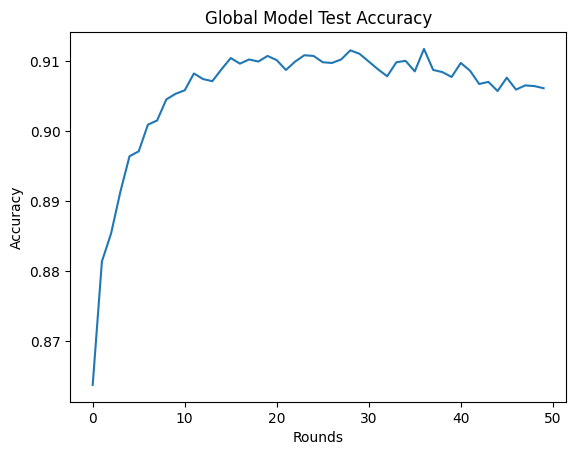

In [17]:
# plot model_test_acc
plt.plot(model_test_acc)
plt.title("Global Model Test Accuracy")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

Text(0, 0.5, 'Loss')

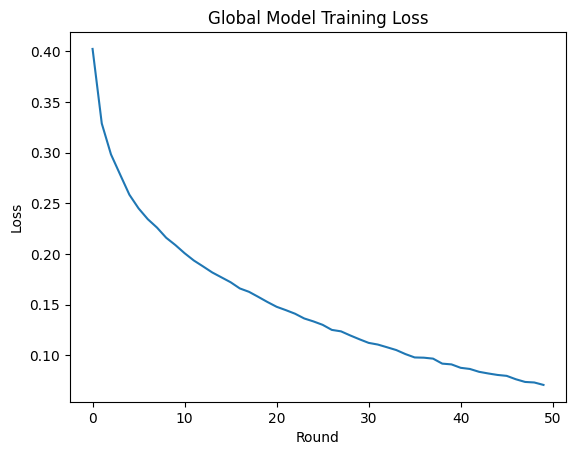

In [18]:
# print and plot training losses for the global model
plt.plot(train_losses)
plt.title("Global Model Training Loss")
plt.xlabel("Round")
plt.ylabel("Loss")

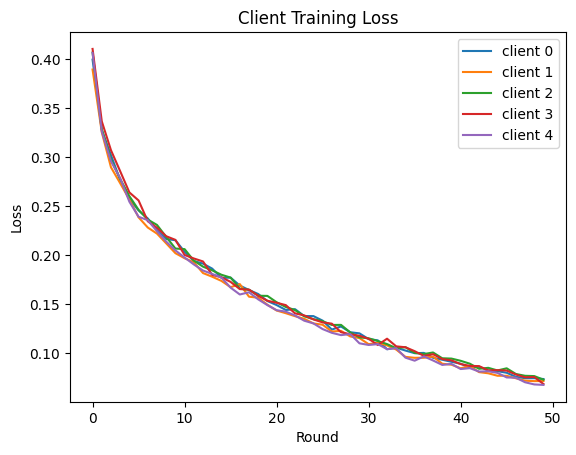

In [19]:
# Plot the loss of each client
for i in range(num_clients):
    plt.plot(clients_loss[i])
    plt.title("Client Training Loss")
    plt.xlabel("Round")
    plt.ylabel("Loss")
plt.legend(["client 0", "client 1", "client 2", "client 3", "client 4"])
plt.show()